<center><h1 style="font-size:2.5vw"> AML Project 2 </h1></center>

---
<div style="display:flex; flex-direction:row; width:35%; justify-content : space-between">
    <div style = "display : flex, flex-direction : column">
        <div><b><font color = "#3285d3">Authors</font></b></div>
        <div><b><font color = "#3285d3">Date</font></b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div>Albert Roathel, Marcel Affi</div>
        <div>April 2021</div>
    </div>
</div>

Feature selection is the process of selecting a subset of relevant features used to train a machine learning model, in this project we have been challenged to use these feature selection methods on two datasets :

<table style="width:100%">
  <tr>
    <th style="text-align:left">Dataset</th>
    <th style="text-align:left">Features</th>
    <th style="text-align:left">Train observations</th>
    <th style="text-align:left">Val observations</th>
  </tr>
  <tr>
    <td style="text-align:left">Artificial</td>
    <td style="text-align:left">500</td>
    <td style="text-align:left">2000</td>
    <td style="text-align:left">600</td>
  </tr>
  <tr>
    <td style="text-align:left">Digits</td>
    <td style="text-align:left">5000</td>
    <td style="text-align:left">6000</td>
    <td style="text-align:left">1000</td>
  </tr>
</table>

# Project outline

1. [Loading Data](#Loading_data)
2. [ElasticNet](#ElasticNet)
3. [Trees](#Trees)
4. [Recursive feature elimination](#RFE)
5. [Boruta](#Boruta)
5. [XGBoost](#XGBoost)

In [63]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import ElasticNetCV, Lasso
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.figsize'] = (10,5)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['grid.color'] = 'w'
plt.style.use(['ggplot'])

import plotly.express as px
import plotly.graph_objects as go

<a id='Loading_data'></a>
# Load and transform the data

In [2]:
def read_from_url(dataset : str) -> (pd.DataFrame):
    train_data   = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_train.data', sep = ' ', header=None).iloc[:,:-1].values
    valid_data   = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_valid.data', sep = ' ', header=None).iloc[:,:-1].values
    train_labels = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_train.labels', header=None).values.ravel()

    return train_data, train_labels, valid_data

In [3]:
X_art, y_art, val_art = read_from_url('artificial')
X_dig, y_dig, val_dig = read_from_url('digits')

In [4]:
# Utility function to save the results
def save_to_file(dataset : str, predictions : np.array, feature_indices : list()):
    with open (f'ALBROE_{dataset}_features.txt', 'w+') as buffer:
        buffer.write("\"ALBROE\"\n")
        for feature_index in feature_indices:
            buffer.write(str(feature_index) + '\n')
    
    with open (f'ALBROE_{dataset}_predictions.txt', 'w+') as buffer:
        buffer.write("\"ALBROE\"\n")
        for prediction in predictions:
            buffer.write(str(prediction) + '\n')

In [5]:
print(f'Artifitial dataset: {X_art.shape[0]} observations, {X_art.shape[1]} features')
print(f'Digits dataset: {X_dig.shape[0]} observations, {X_dig.shape[1]} features')

Artifitial dataset: 2000 observations, 500 features
Digits dataset: 6000 observations, 5000 features


In [6]:
X_art = (X_art - X_art.mean(0)) / X_art.std()
val_art = (val_art - val_art.mean(0)) / val_art.std()

In [7]:
std = X_dig.std(0)
X_dig = X_dig[:, std != 0]
X_dig = (X_dig - X_dig.mean(0)) / std[std != 0]


In [8]:
X_art_train, X_art_test, y_art_train, y_art_test = sklearn.model_selection.train_test_split(
    X_art, y_art, test_size=0.33, random_state=42)

X_dig_train, X_dig_test, y_dig_train, y_dig_test = sklearn.model_selection.train_test_split(
    X_dig, y_dig, test_size=0.33, random_state=42)

#  Predictive model

We selected SVM as a final model for prediction. We will at first select features using methods such as trees, Boruta etc and then based on those features SVM model with best hyerparameters will be selected via crossvalidation. 

In [87]:
def select_best_svm(X, y):
    svm = SVC(kernel='rbf')
    params = {
        'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
        'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]
    }
    searcher = GridSearchCV(svm, params, scoring=['accuracy', 'f1'], refit='f1', cv=5, n_jobs=-1, verbose=1)
    searcher.fit(X, y)
    results = pd.pivot_table(
        pd.DataFrame(searcher.cv_results_)\
        .loc[:, ['param_C', 'param_gamma', 'mean_test_f1', 'mean_test_accuracy']],
        columns='param_C', index='param_gamma', values='mean_test_accuracy'
    ).round(4) * 100
    return searcher, results


<a id='ElasticNet'></a>
# ElasticNet

In [28]:
elasticnet = ElasticNetCV(
    l1_ratio=[0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.9, 0.95, 0.99, 1],
    verbose=1
)

In [10]:
elasticnet.fit(X_art_train, y_art_train.flatten())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(l1_ratio=[0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.9, 0.95, 0.99, 1],
             verbose=1)

In [11]:
elasticnet.l1_ratio_, elasticnet.alpha_

(1.0, 0.06543605558779328)

In [29]:
lasso = Lasso(alpha=0.06)
lasso.fit(X_art_train, y_art_train)

Lasso(alpha=0.06)

In [30]:
pred = np.ones(X_art_test.shape[0])
pred[lasso.predict(X_art_test) < 0] = -1

In [31]:
(pred == y_art_test).mean()

0.5848484848484848

In [32]:
art_lasso_selection = lasso.coef_ != 0

In [88]:
svm_lasso, svm_lasso_results = select_best_svm(
    X_art_train[:, art_lasso_selection],
    y_art_train
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   14.6s finished


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

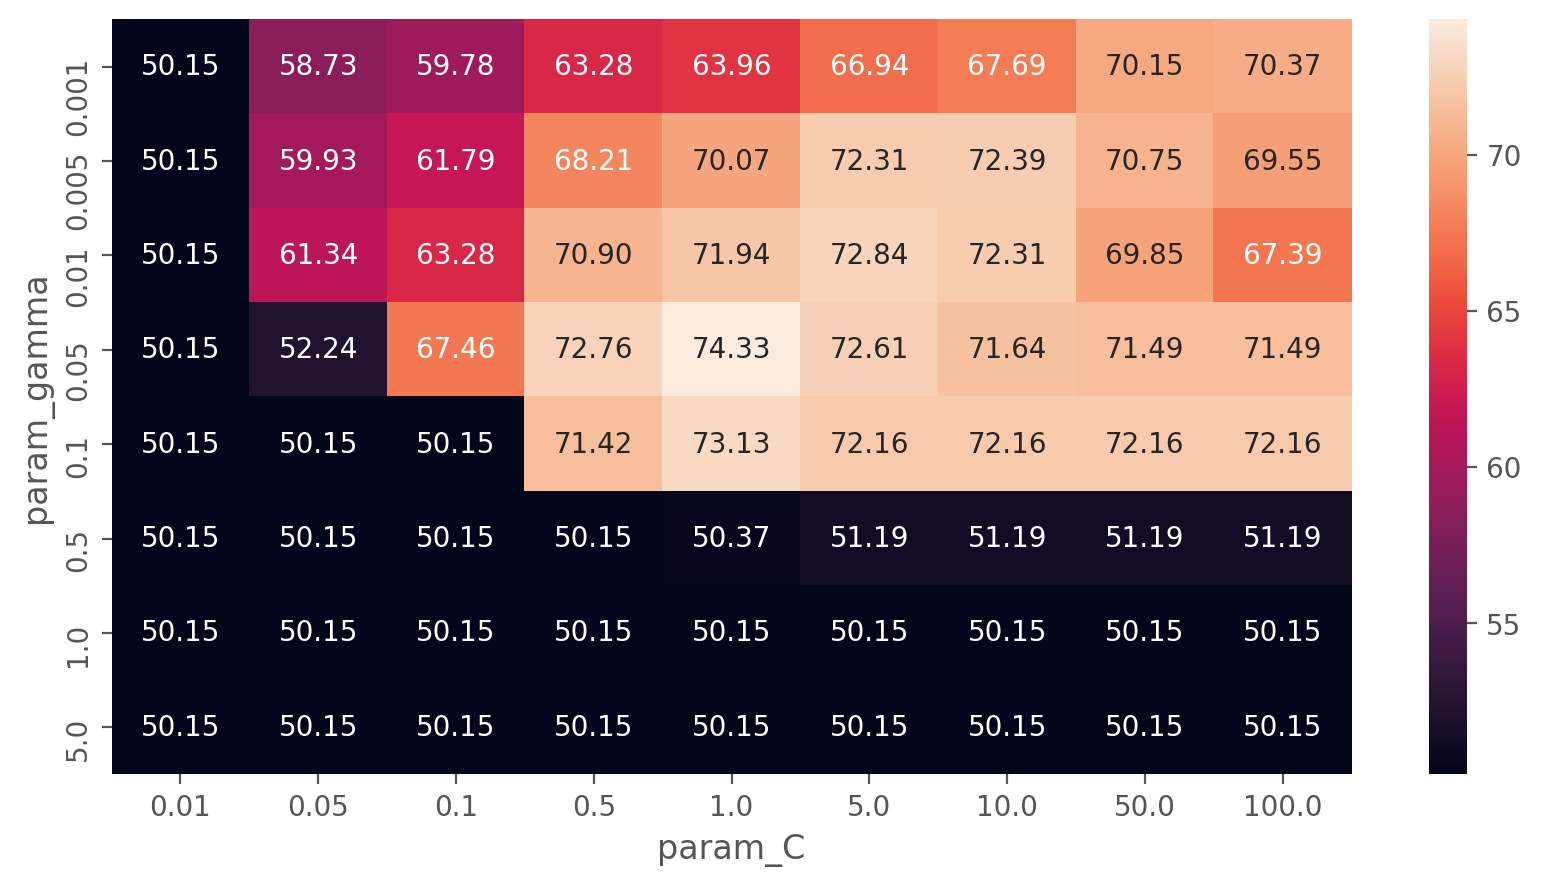

In [89]:
sns.heatmap(svm_lasso_results, annot=True, fmt='.2f')

In [98]:
svm = SVC(kernel='rbf', C=1, gamma=0.05)
svm.fit(X_art_train[:, art_lasso_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_lasso_selection])
(pred == y_art_test).mean()

0.6954545454545454

<a id='Trees'></a>
# Trees

In [284]:
X_dig_train.shape

(4020, 4955)

In [285]:
trees = ExtraTreesClassifier(n_estimators=500, criterion='gini', min_samples_split=10,
                    max_features=300)

In [286]:
trees.fit(X_art_train, y_art_train)

ExtraTreesClassifier(max_features=300, min_samples_split=10, n_estimators=500)

In [287]:
pred = trees.predict(X_art_test)

In [288]:
(pred == y_art_test).mean()

0.8378787878787879

In [289]:
px.histogram(trees.feature_importances_)

In [290]:
art_extra_tree_selection = trees.feature_importances_ > 0.005
art_extra_tree_selection.sum()

20

In [291]:
trees_better = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=3,
                    max_features=5)

trees_better.fit(X_art_train[:,art_extra_tree_selection], y_art_train)
pred = trees.predict(X_art_test)
(pred == y_art_test).mean()


0.8378787878787879

In [292]:
svm_extra_trees, svm_extra_trees_results = select_best_svm(
    X_art_train[:, art_extra_tree_selection],
    y_art_train
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   17.8s finished


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

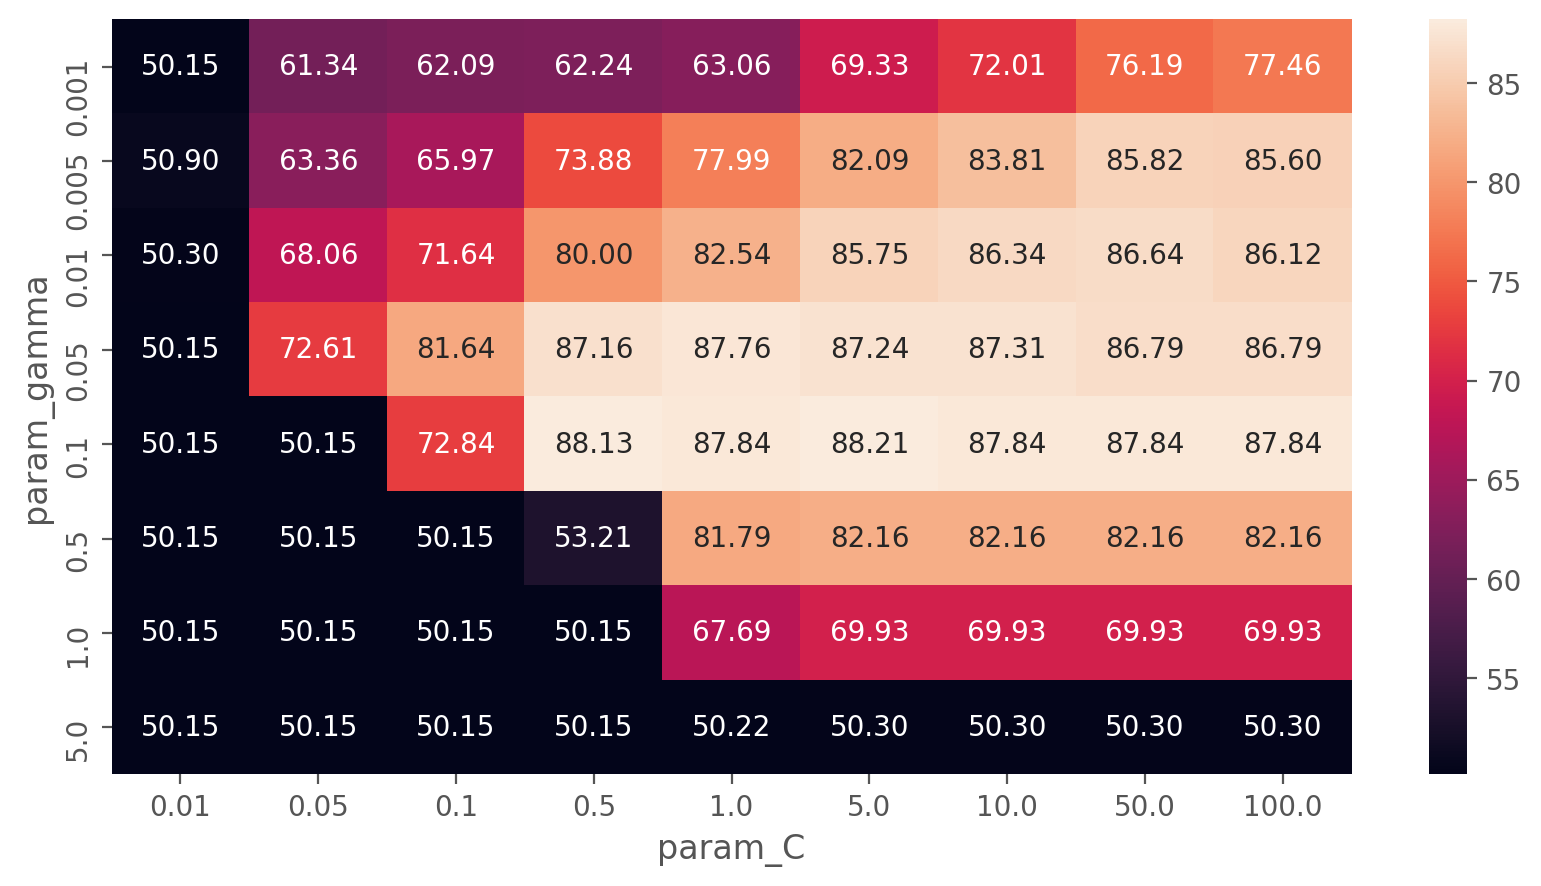

In [293]:
sns.heatmap(svm_extra_trees_results, annot=True, fmt='.2f')

In [294]:
# check the model with best hyperparameters
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm.fit(X_art_train[:, art_extra_tree_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_extra_tree_selection])
(pred == y_art_test).mean()

0.906060606060606

In [295]:
# train on all available data
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm.fit(X_art[:, art_extra_tree_selection], y_art)

SVC(C=1, gamma=0.1, probability=True)

# Feature importance with SVM

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

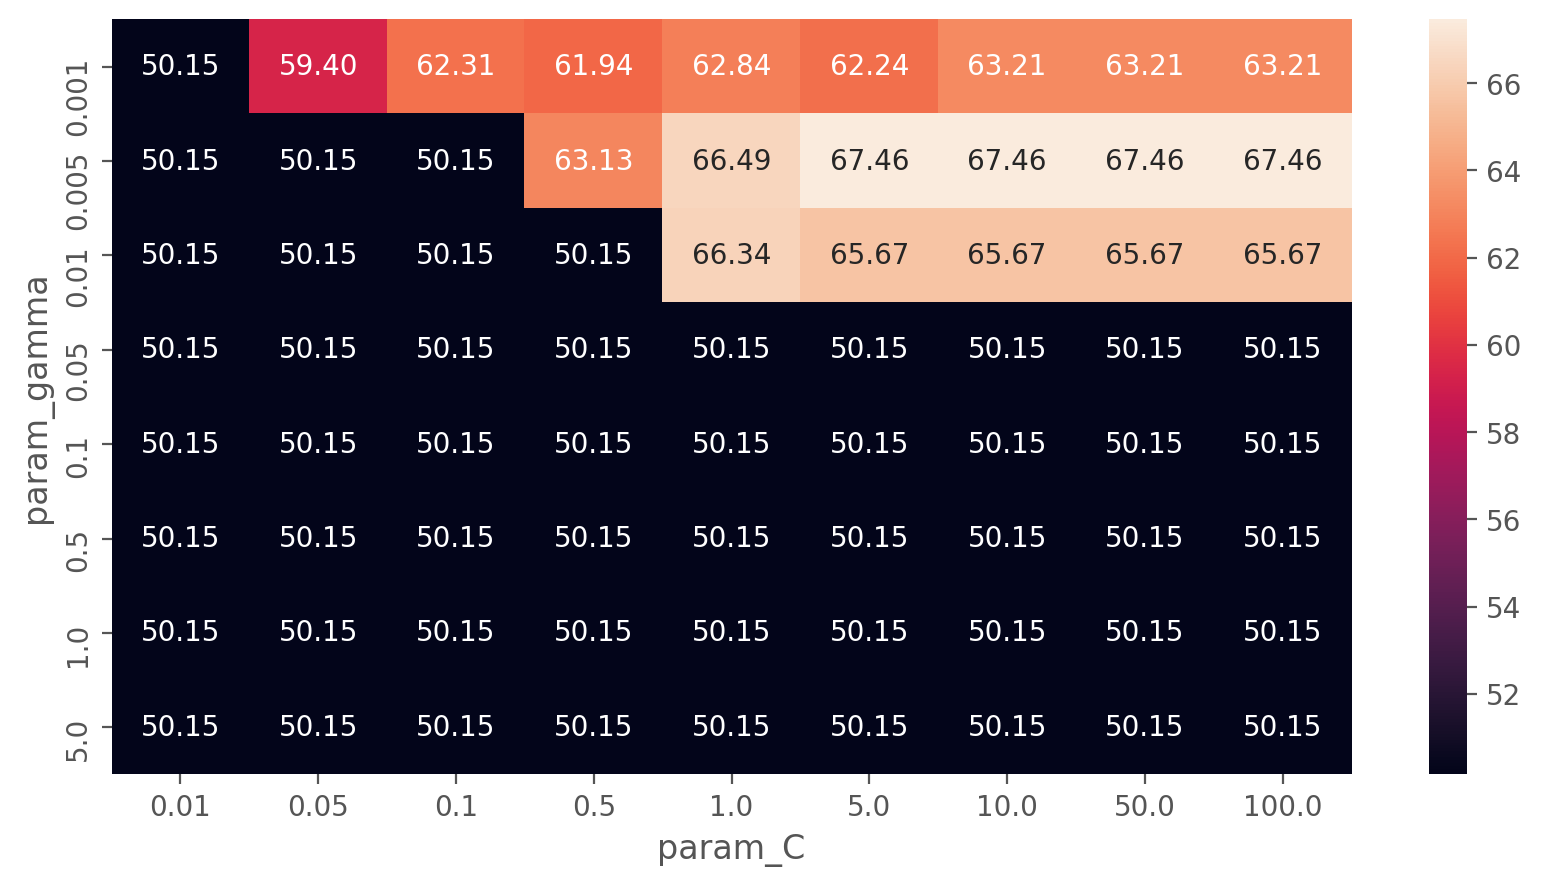

In [135]:
svm, svm_results = select_best_svm(X=X_art_train, y=y_art_train)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [154]:
svm = SVC(kernel='rbf', C=10, gamma=0.005)
svm.fit(X_art_train, y_art_train)
pred = svm.predict(X_art_test)
(pred == y_art_test).mean()

0.65

In [159]:
importance = permutation_importance(svm, X=X_art_train, y=y_art_train, n_repeats=4, n_jobs=-1)

In [160]:
px.histogram(importance['importances_mean'])

In [181]:
art_FI_selection = importance['importances_mean'] != 0
sum(art_FI_selection)

3

In [182]:
svm = SVC(C=100, kernel='rbf', gamma=0.01)
svm.fit(X_art_train[:, art_FI_selection], y_art_train)
pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test[:, art_FI_selection]) < 0] = -1
(pred == y_art_test).mean()

0.6424242424242425

<a id='RFE'></a>

# Recursive feature elimination

In [142]:
from sklearn.feature_selection import RFE

In [143]:
gradboost = GradientBoostingClassifier(n_estimators=500, max_depth=10, max_features='auto')
gradboost.fit(X_art_train, y_art_train)
pred = gradboost.predict(X_art_test) 
(pred == y_art_test).mean()

0.7636363636363637

In [146]:
gradboost = GradientBoostingClassifier(n_estimators=50, max_depth=10, max_features='auto')
rfe = RFE(gradboost, n_features_to_select=20, step=50, verbose=1)
rfe.fit(X_art_train, y_art_train)

Fitting estimator with 500 features.
Fitting estimator with 450 features.
Fitting estimator with 400 features.
Fitting estimator with 350 features.
Fitting estimator with 300 features.
Fitting estimator with 250 features.
Fitting estimator with 200 features.
Fitting estimator with 150 features.
Fitting estimator with 100 features.
Fitting estimator with 50 features.


RFE(estimator=GradientBoostingClassifier(max_depth=10, max_features='auto',
                                         n_estimators=50),
    n_features_to_select=20, step=50, verbose=1)

In [147]:
art_rfe_selection = rfe.ranking_ == 1

In [150]:
pred = rfe.estimator_.predict(X_art_test[:, art_rfe_selection])
(pred == y_art_test).mean()

0.7727272727272727

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 353 out of 360 | elapsed:   19.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   20.0s finished


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

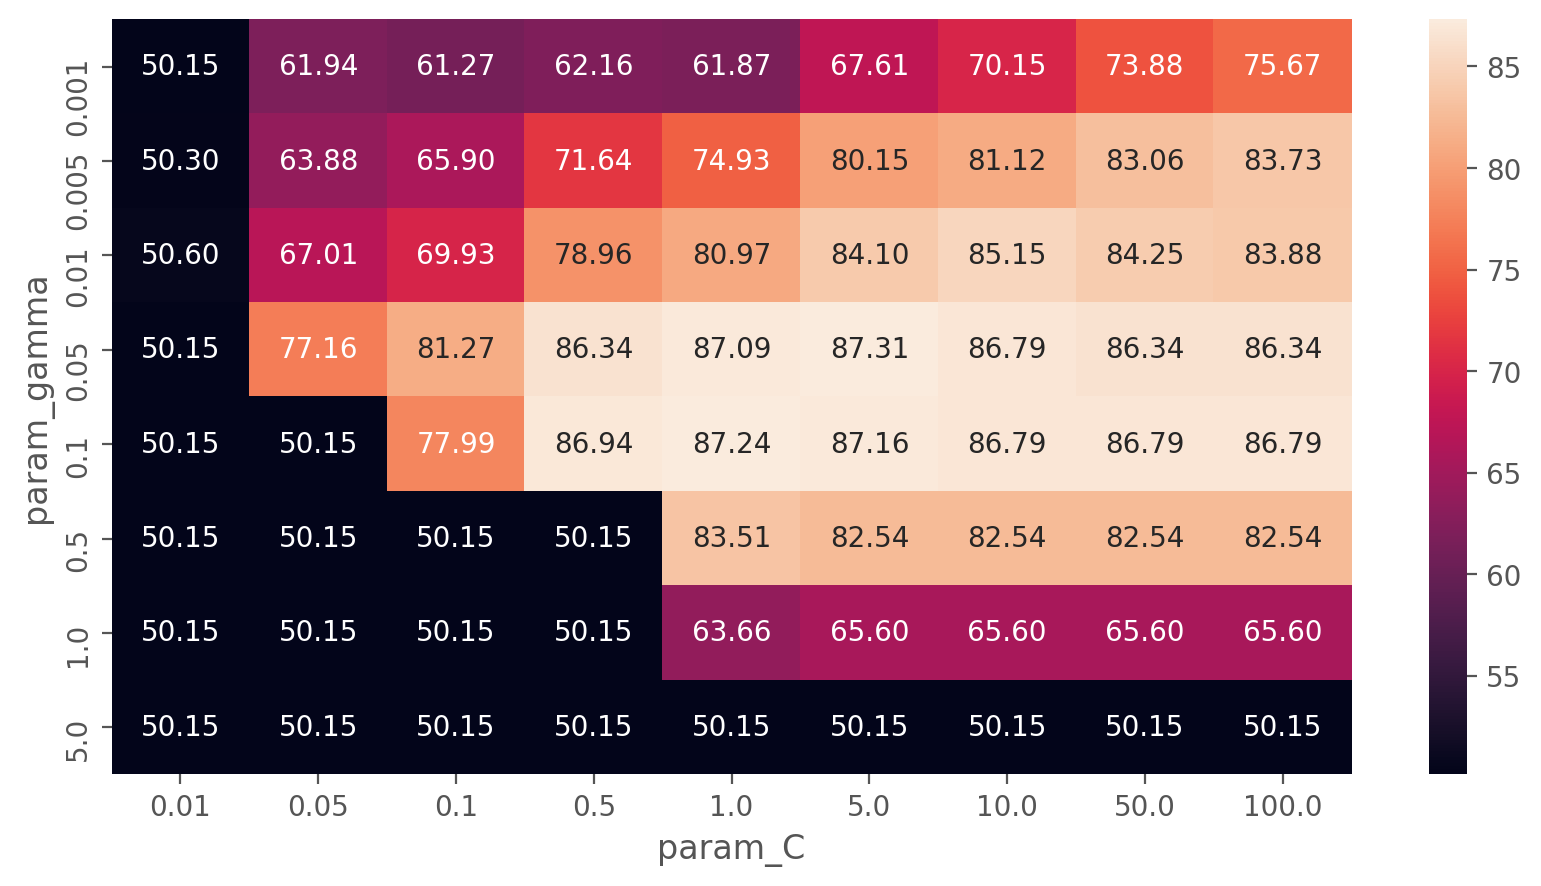

In [151]:
svm, svm_results = select_best_svm(X=X_art_train[:, art_rfe_selection], y=y_art_train)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [153]:
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_art_train[:, art_rfe_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_rfe_selection])
(pred == y_art_test).mean()

0.8939393939393939

<a id='Boruta'></a>
# Boruta

In [166]:
from boruta import BorutaPy
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [183]:
trees = ExtraTreesClassifier(n_estimators=100, criterion='gini', min_samples_split=10,
                    max_features='auto')
feat_selector = BorutaPy(trees, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X_art_train, y_art_train)
art_boruta_selection = feat_selector.support_
feat_selector.ranking_
# X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	479
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	16 / 100
Confirmed: 	16
Tenta

array([105, 316, 453, 435,  62,  53, 210, 341, 196,  87,  57,  72,  41,
       299, 165, 180,  24, 348,  19, 107, 348, 267, 432, 306, 177, 361,
        97, 385,   1, 280, 351, 468,  78, 220, 429,  75, 180, 440,  83,
       299, 416, 411, 336,  59, 228, 394,   1, 312,   1, 247, 169, 185,
       354,  14, 263, 110,  29, 387, 481, 293,  61, 476, 445, 268,   1,
       297, 343, 175, 220, 146, 400, 428, 397, 309,  65, 237, 225,  98,
        55, 116, 259, 118, 238, 241, 126, 201, 173, 327, 252, 452, 383,
       227, 365, 365, 245, 317, 426,  74, 388, 275, 210, 353,  60, 400,
       306,   1, 234, 467, 304, 148, 159, 173, 286, 402, 178, 236,  91,
        84, 460, 245, 165, 190, 337, 260,  76,  27, 201, 216,   1, 477,
        35, 163, 403, 301, 216, 310,   9,  99, 161, 208, 111, 308, 285,
       327, 248, 206, 112,  45,  68,  58, 266, 360, 231,   1, 233, 171,
        24, 220, 424, 379, 179,  30, 439, 161, 155,  53, 102,  93, 272,
       480, 385, 331, 127,  31, 183,  86, 151,   5, 408, 379,  6

In [179]:
trees = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', min_samples_split=2,
                    max_features='sqrt')
trees.fit(X_art_train[:, art_boruta_selection], y_art_train)
pred = trees.predict(X_art_test[:, art_boruta_selection])
(pred == y_art_test).mean()

0.9

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.2s finished


<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

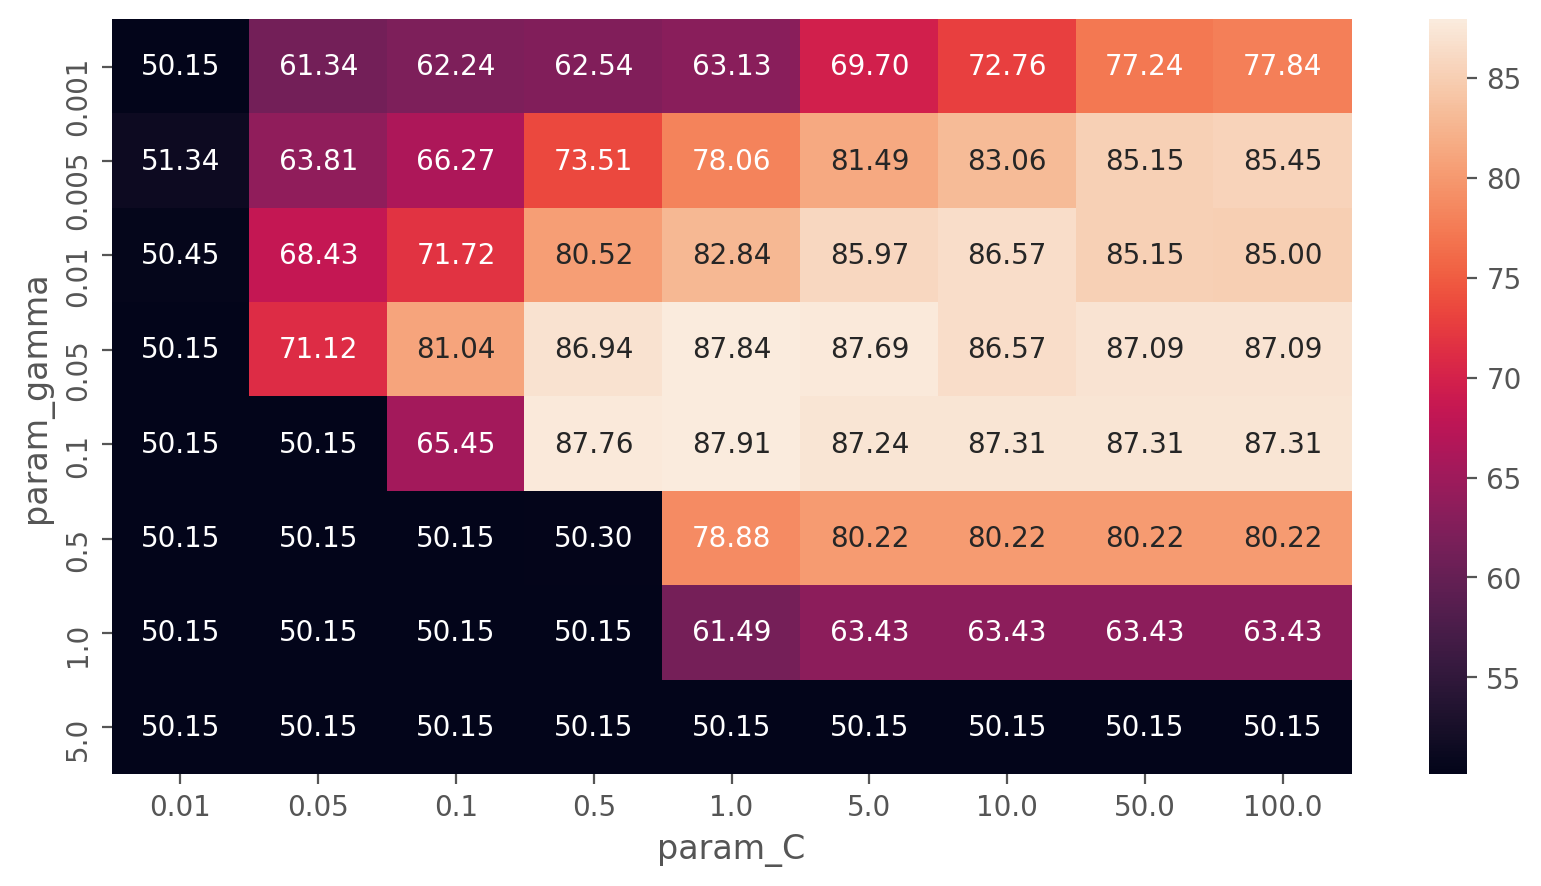

In [184]:
svm, svm_results = select_best_svm(X=X_art_train[:, art_boruta_selection], y=y_art_train)
sns.heatmap(svm_results, annot=True, fmt='.2f')

In [185]:
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_art_train[:, art_rfe_selection], y_art_train)
pred = svm.predict(X_art_test[:, art_rfe_selection])
(pred == y_art_test).mean()

0.8939393939393939

<a id='XGBoost'></a>
# XGBoost

### Atrificial dataset

In [188]:
import xgboost as xgb
import shap
dtrain = xgb.DMatrix(X_art_train, label=y_art_train)
dtest = xgb.DMatrix(X_art_test, label=y_art_test)

In [222]:
num_round = 100
param = {'max_depth':10, 'eta': 0.1, 'alpha': 2, 'tree_method': 'hist'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param['nthread'] = 5
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-rmse:1.05411	train-rmse:1.02234
[1]	eval-rmse:1.00653	train-rmse:0.93741
[2]	eval-rmse:0.96409	train-rmse:0.85920
[3]	eval-rmse:0.92889	train-rmse:0.78844
[4]	eval-rmse:0.90083	train-rmse:0.72623
[5]	eval-rmse:0.87580	train-rmse:0.66857
[6]	eval-rmse:0.85515	train-rmse:0.61781
[7]	eval-rmse:0.83946	train-rmse:0.57235
[8]	eval-rmse:0.82859	train-rmse:0.53123
[9]	eval-rmse:0.81830	train-rmse:0.49290
[10]	eval-rmse:0.80729	train-rmse:0.45966
[11]	eval-rmse:0.79705	train-rmse:0.42948
[12]	eval-rmse:0.79180	train-rmse:0.40683
[13]	eval-rmse:0.78933	train-rmse:0.38527
[14]	eval-rmse:0.78218	train-rmse:0.36188
[15]	eval-rmse:0.77810	train-rmse:0.34291
[16]	eval-rmse:0.77269	train-rmse:0.32343
[17]	eval-rmse:0.76913	train-rmse:0.30889
[18]	eval-rmse:0.76685	train-rmse:0.29439
[19]	eval-rmse:0.76440	train-rmse:0.28172
[20]	eval-rmse:0.76399	train-rmse:0.27238
[21]	eval-rmse:0.76429	train-rmse:0.26058
[22]	eval-rmse:0.76222	train-rmse:0.24932
[23]	eval-rmse:0.76175	train-rmse:0.23847
[2

In [223]:
pred = bst.predict(dtest, iteration_range=(0, bst.best_iteration))
pred[pred > 0] = 1
pred[pred < 0] = -1
(pred == y_art_test).mean()

0.803030303030303

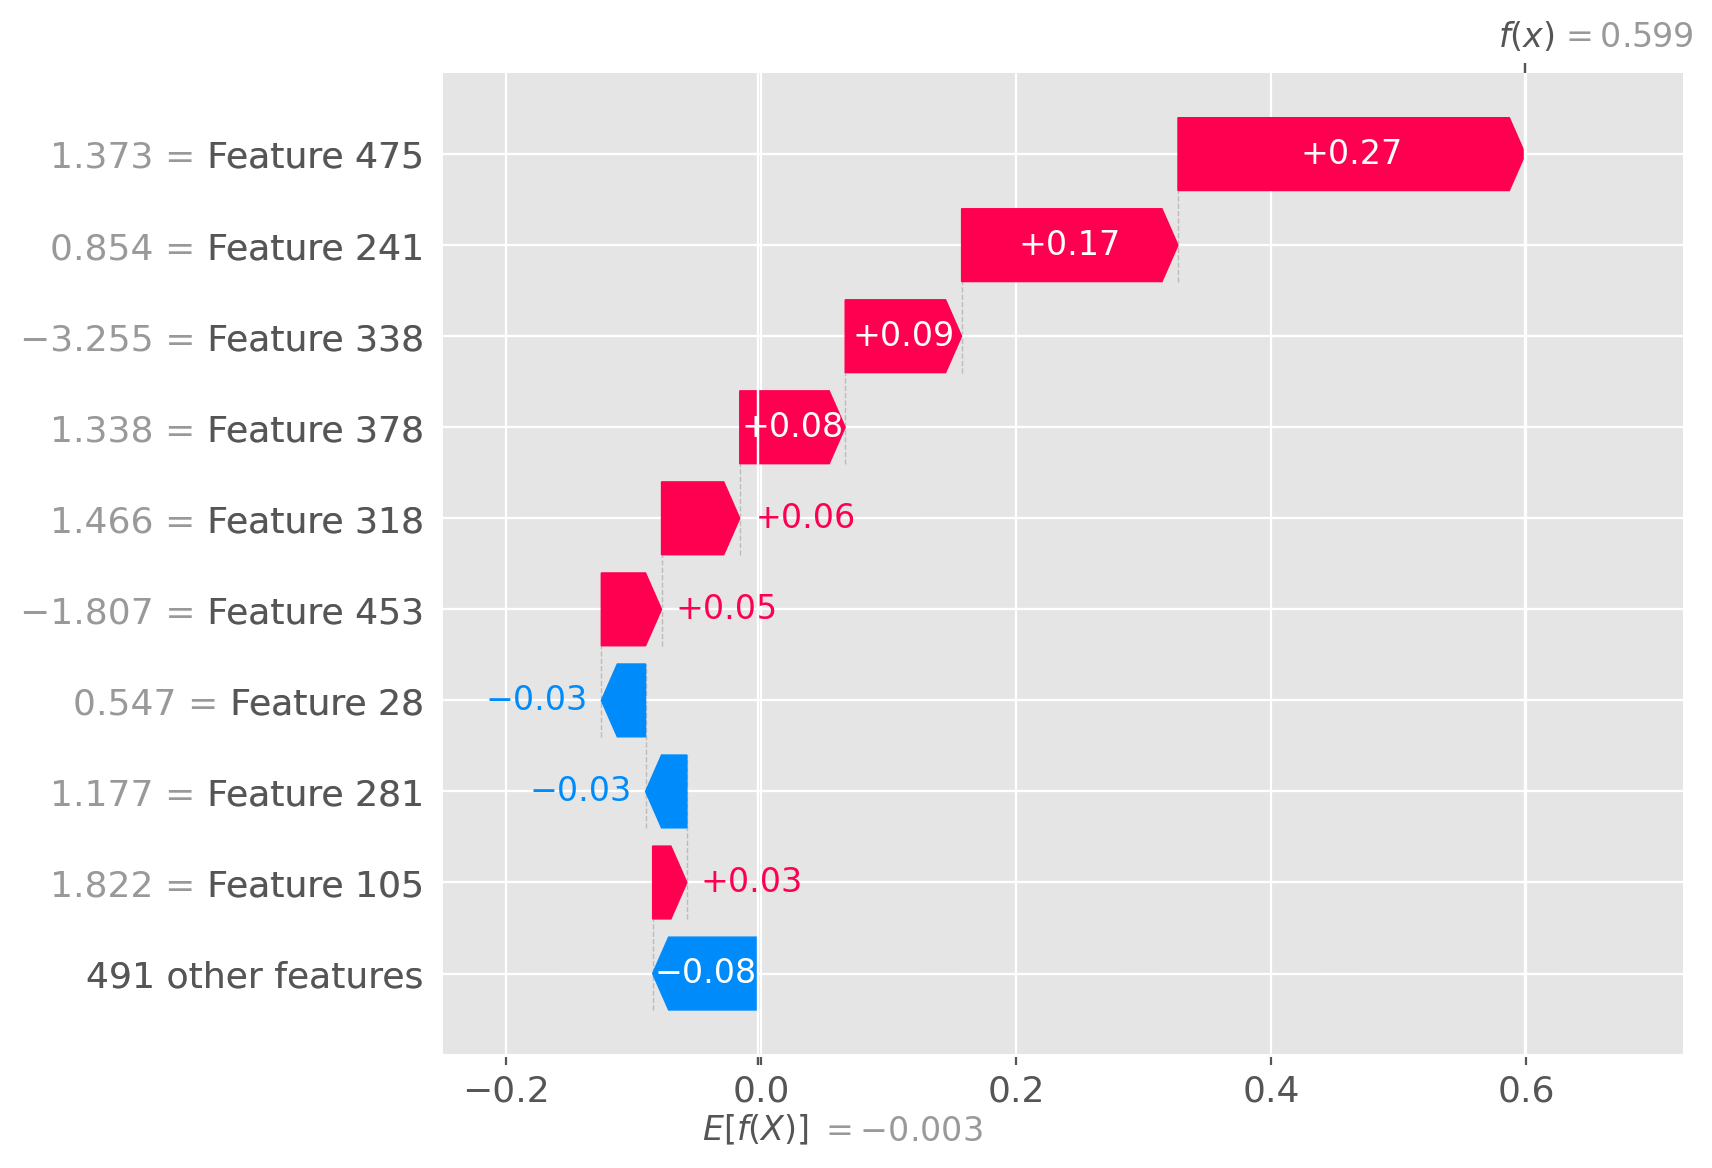

In [224]:
xgboost_explainer = shap.Explainer(bst)
xgboost_shap_values = xgboost_explainer(X_art_test)

# visualize the first prediction's explanation
shap.plots.waterfall(xgboost_shap_values[0])

As you see in the graph, feature 475 has the most impact on the model 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

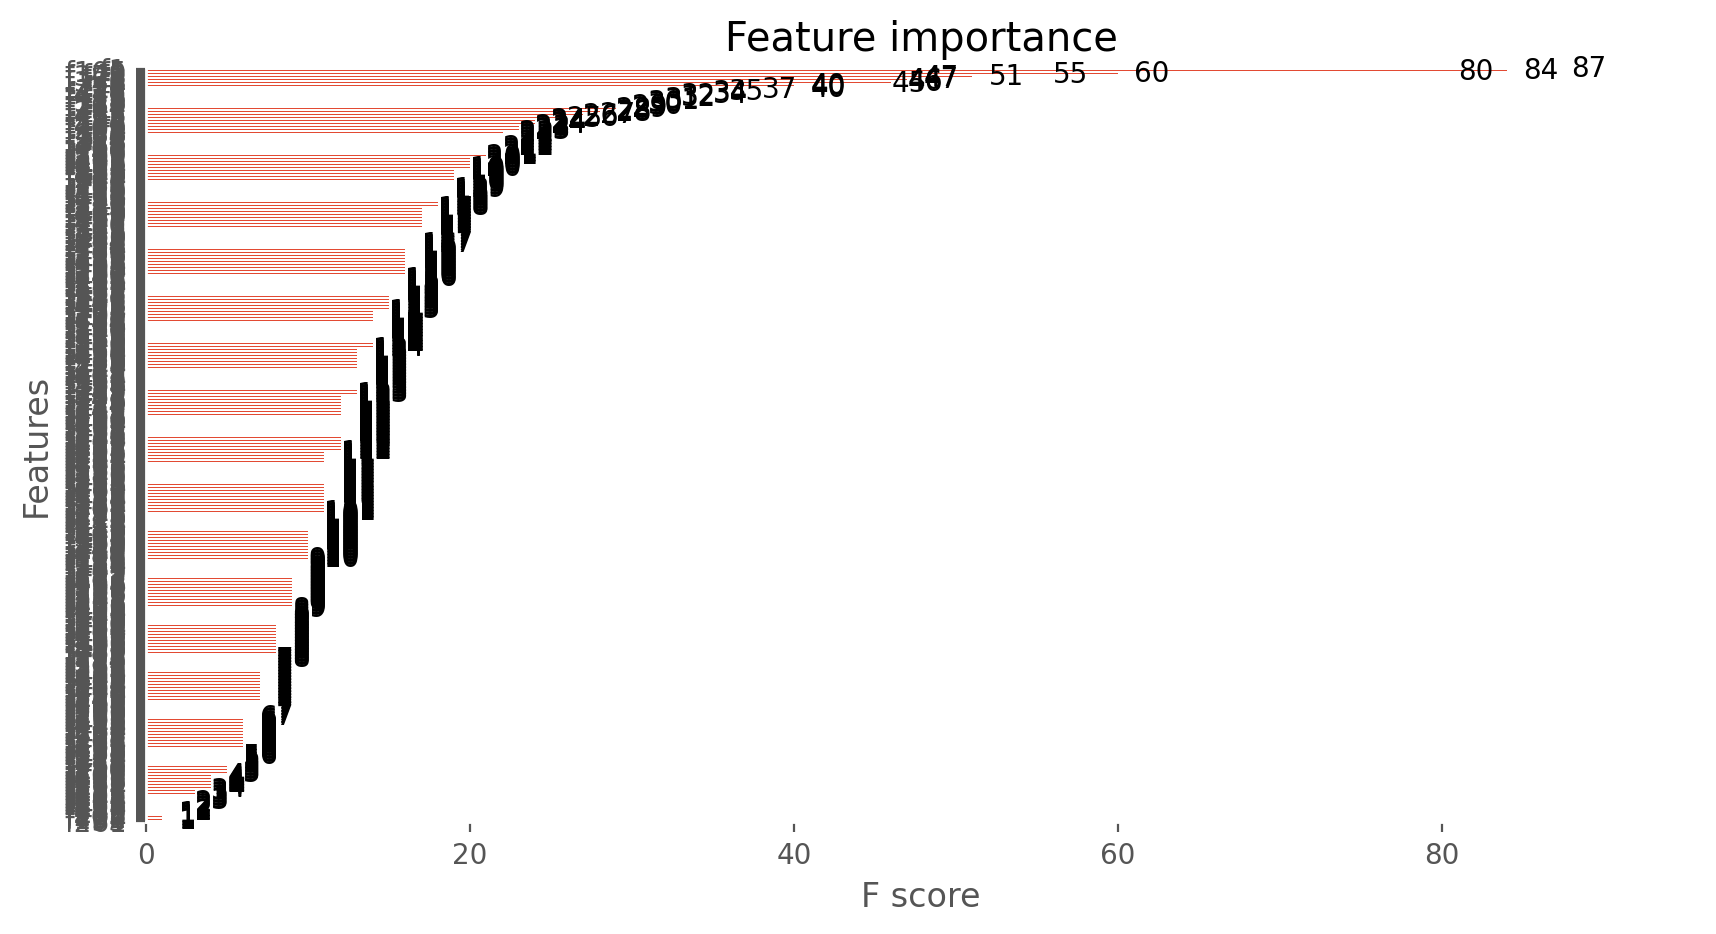

In [225]:
xgb.plot_importance(bst)

In [226]:
shap.initjs()
shap.plots.force(xgboost_shap_values[0])

here you can compare the SHAP value for feature 475 as compared to other features, to do so just change the index from 475 to any other feature index

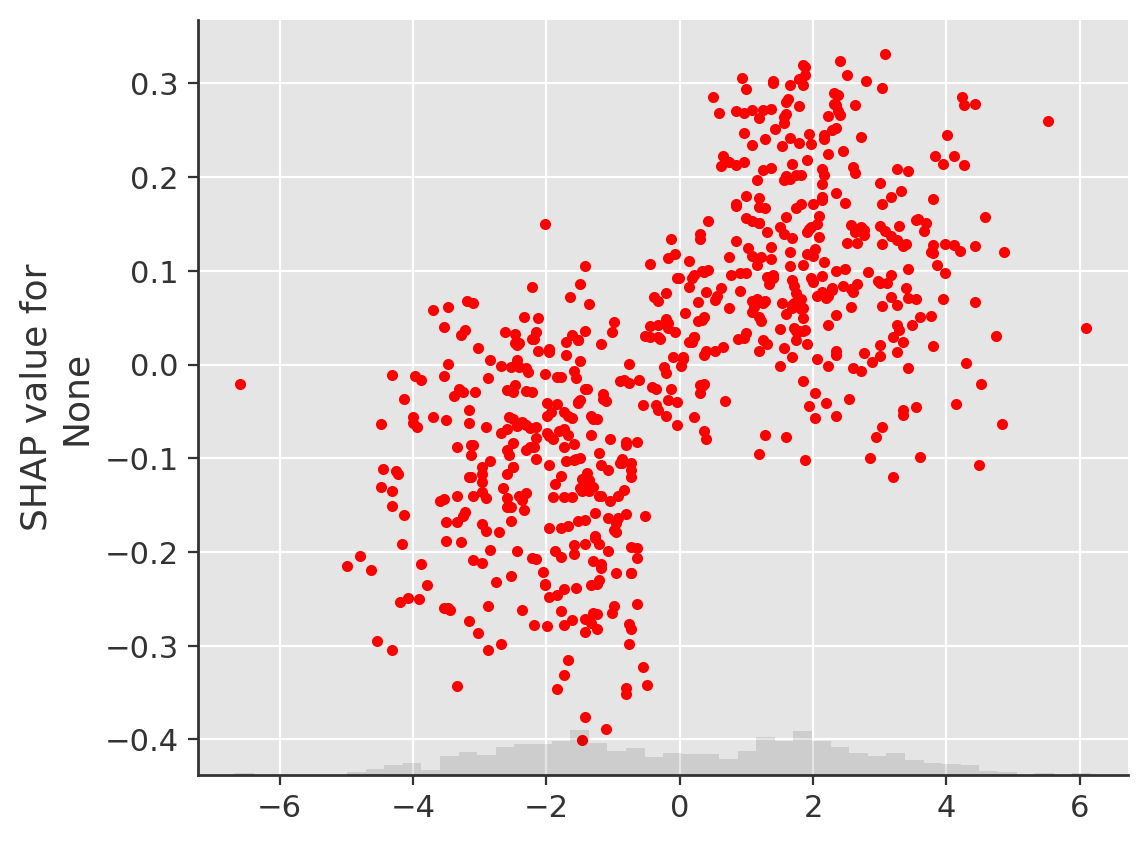

In [227]:
shap.initjs()
shap.plots.scatter(xgboost_shap_values[:,475], color='red')

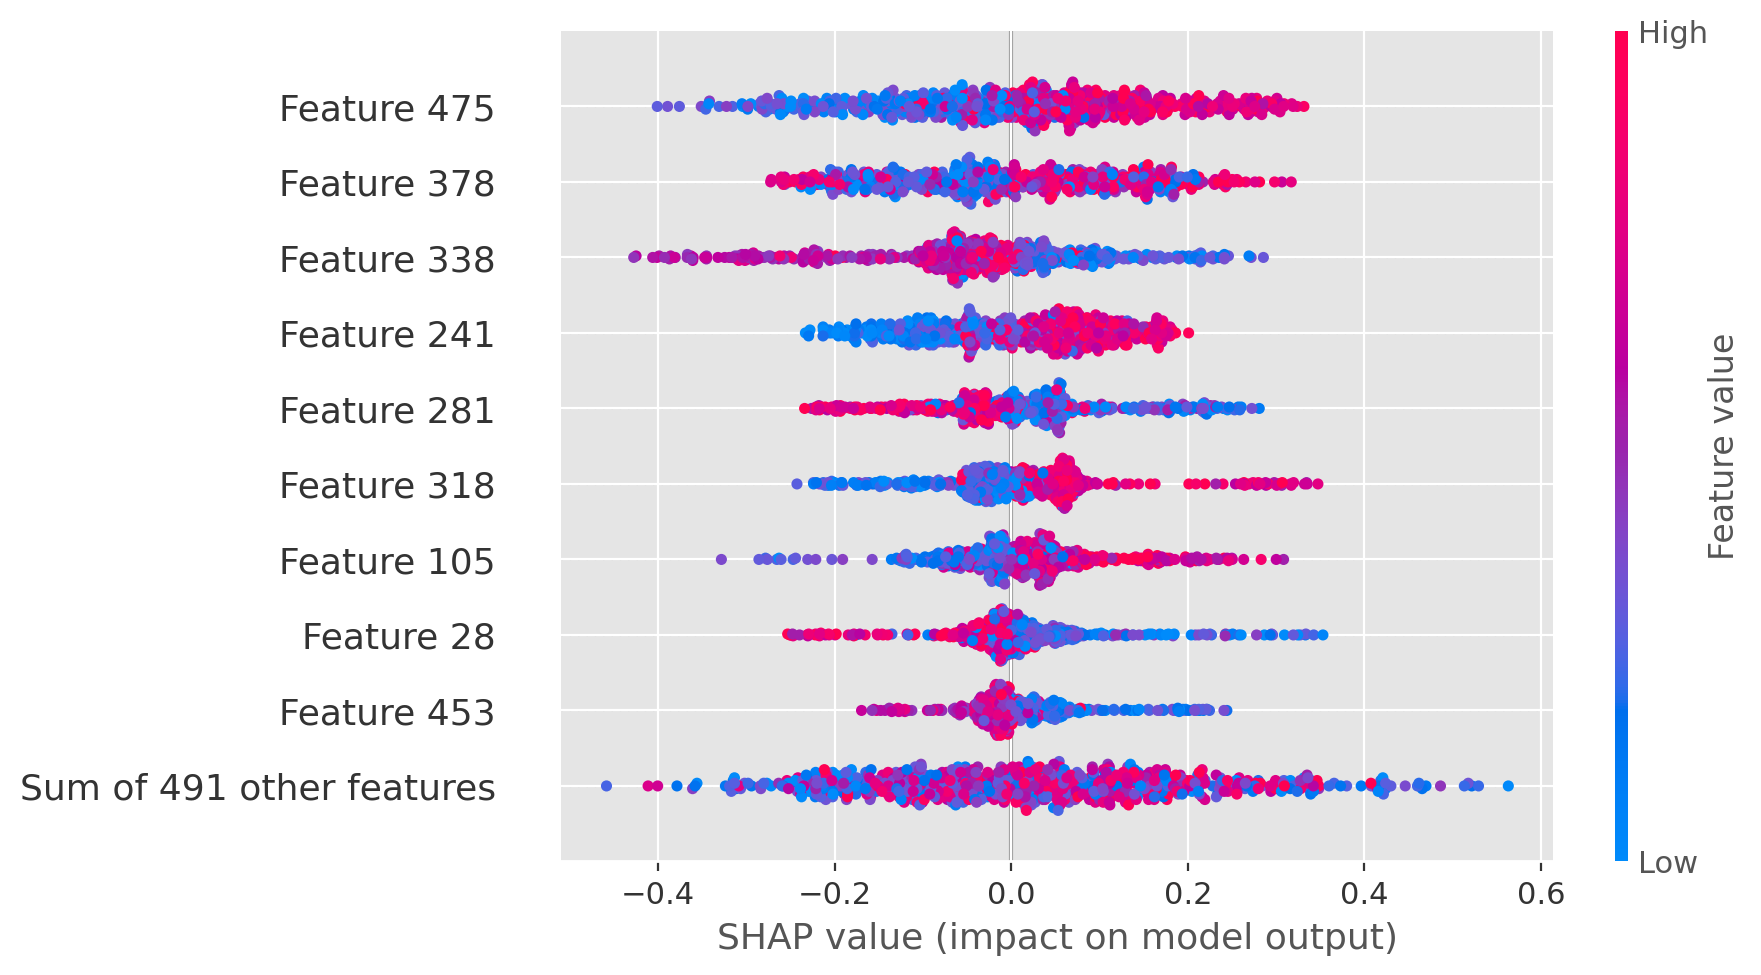

In [228]:
shap.plots.beeswarm(xgboost_shap_values)

In [ ]:
xgb.to_graphviz(bst, num_trees=2)

In [230]:
N = len(bst.get_fscore())
total = np.array(list(bst.get_fscore().values())).sum()
importances = bst.get_fscore()
importances.update((x, y/total) for x, y in importances.items())
importances_list = np.zeros(X_art.shape[1])
for feature, importance in importances.items():
    importances_list[int(feature.split('f')[1])] = importance

In [231]:
selected_importances = {feature:importance for feature, importance in importances.items() if importance > 0.05}
selected_importances

{}

In [232]:
important_features = importances_list > 0.05

In [ ]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(X_art_train[:, important_features], y_art_train)

pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test[:, important_features]) < 0] = -1
(pred == y_art_test).mean()

### Digits dataset

In [151]:
dtrain = xgb.DMatrix(X_dig_train, label=y_dig_train)
dtest = xgb.DMatrix(X_dig_test, label=y_dig_test)

In [152]:
num_round = 4
param = {'max_depth':2, 'eta': 0.1}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param['nthread'] = 5
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-rmse:1.04461	train-rmse:1.04003
[1]	eval-rmse:0.97866	train-rmse:0.97340
[2]	eval-rmse:0.92039	train-rmse:0.91545
[3]	eval-rmse:0.86566	train-rmse:0.86110


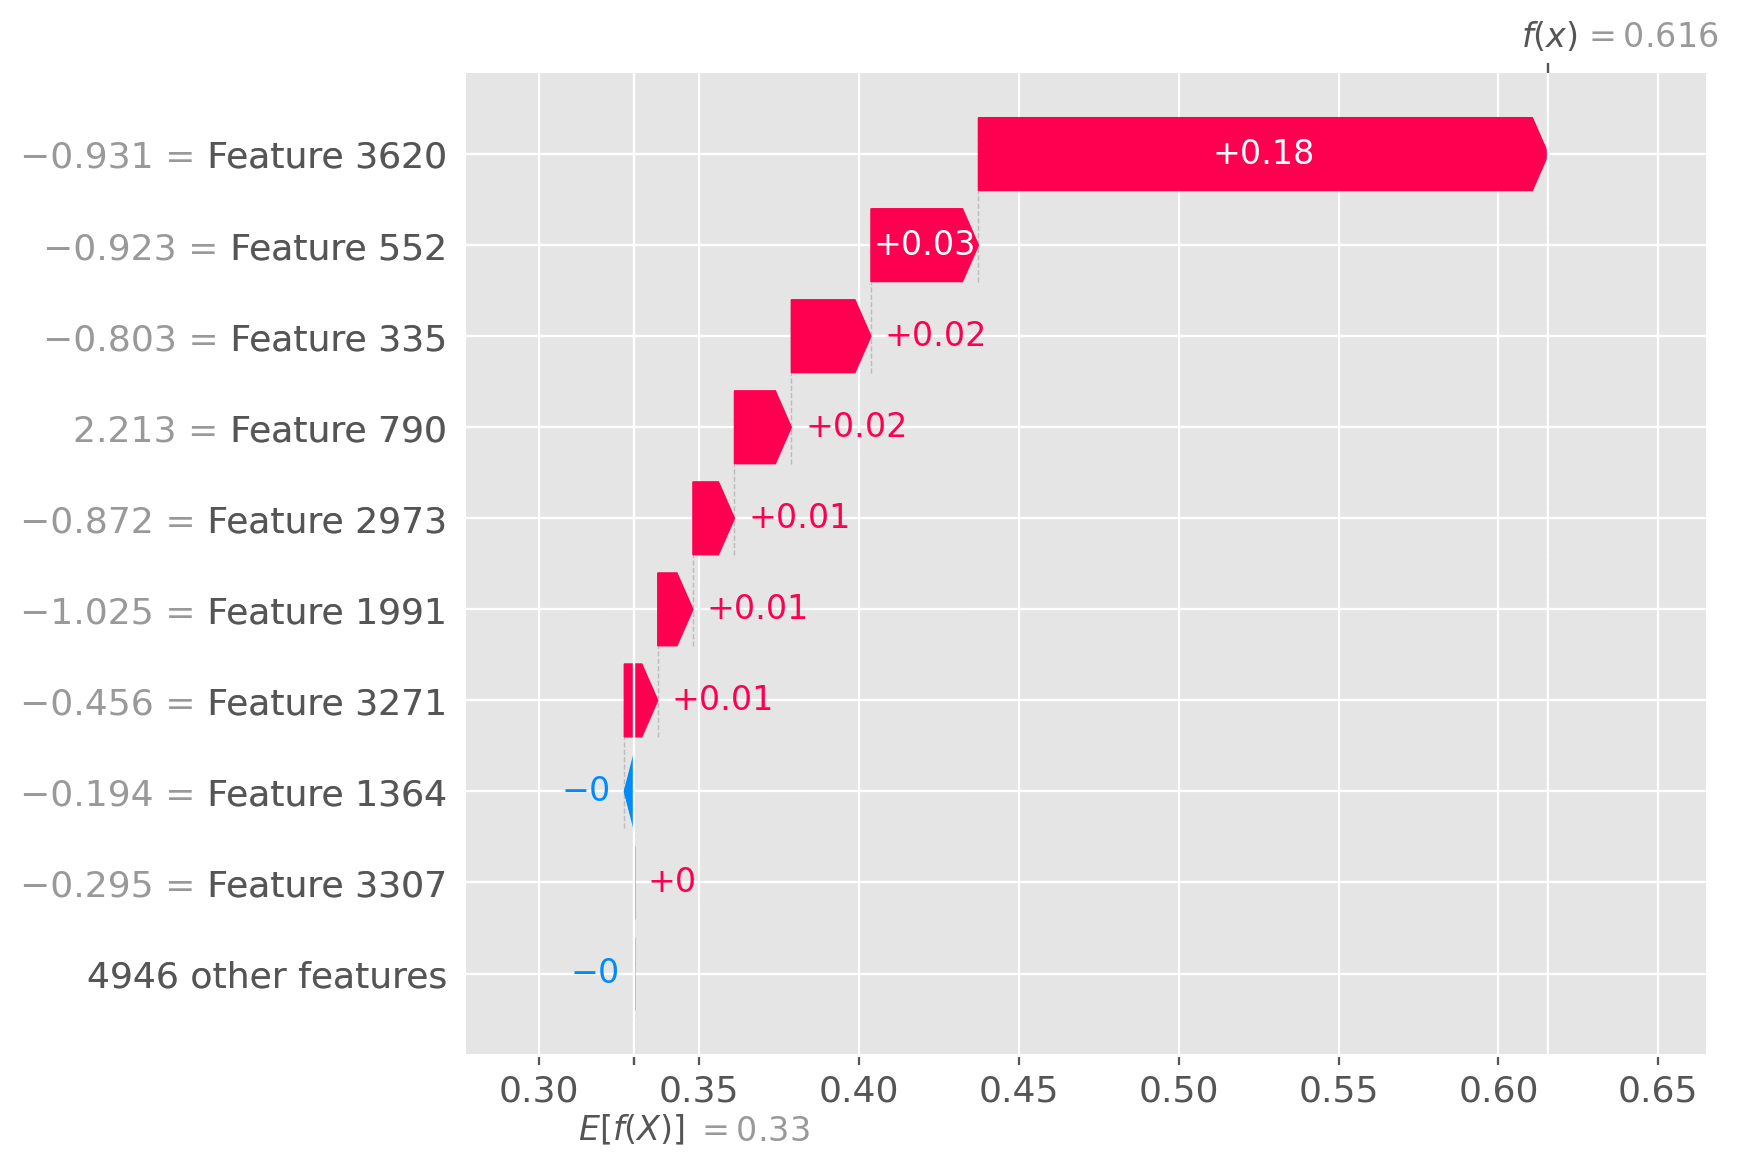

In [153]:
xgboost_explainer = shap.Explainer(bst)
xgboost_shap_values = xgboost_explainer(X_dig_test)

# visualize the first prediction's explanation
shap.plots.waterfall(xgboost_shap_values[0])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

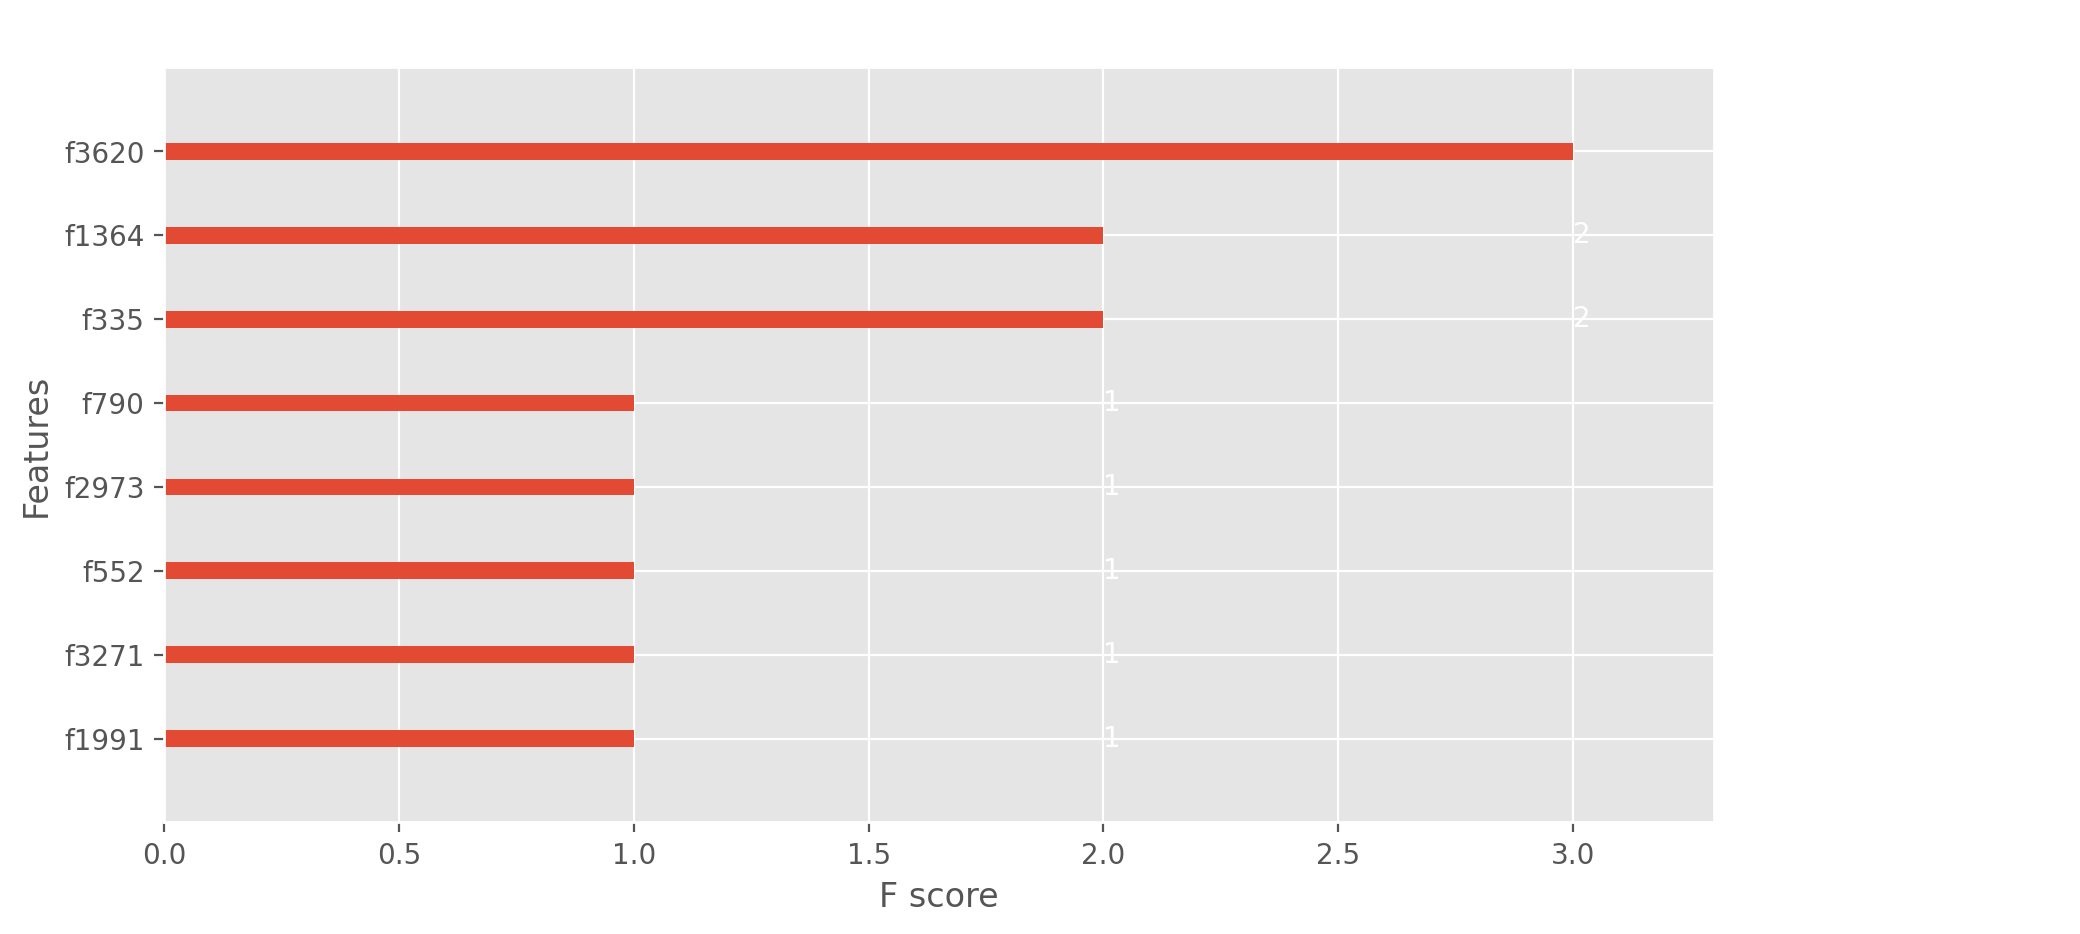

In [154]:
xgb.plot_importance(bst)

In [155]:
shap.initjs()
shap.plots.force(xgboost_shap_values[0])

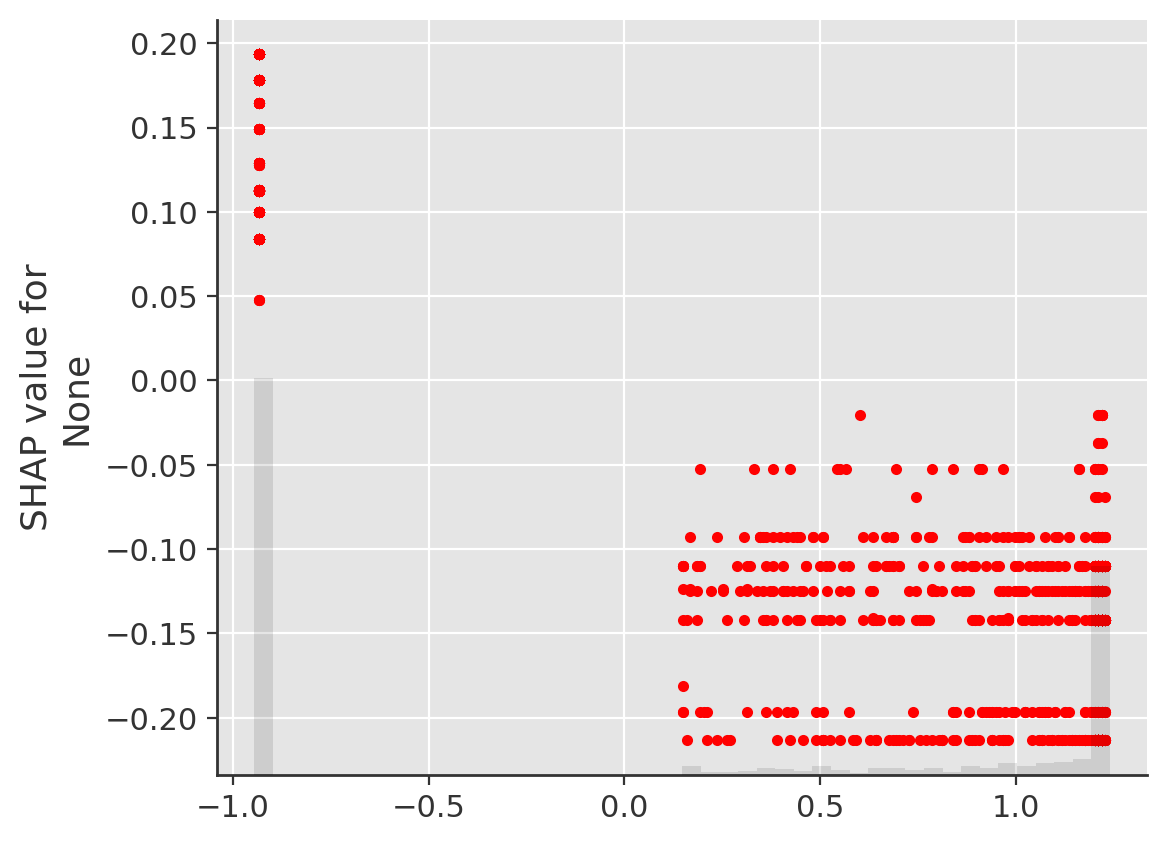

In [156]:
shap.initjs()
shap.plots.scatter(xgboost_shap_values[:,3620], color='red')

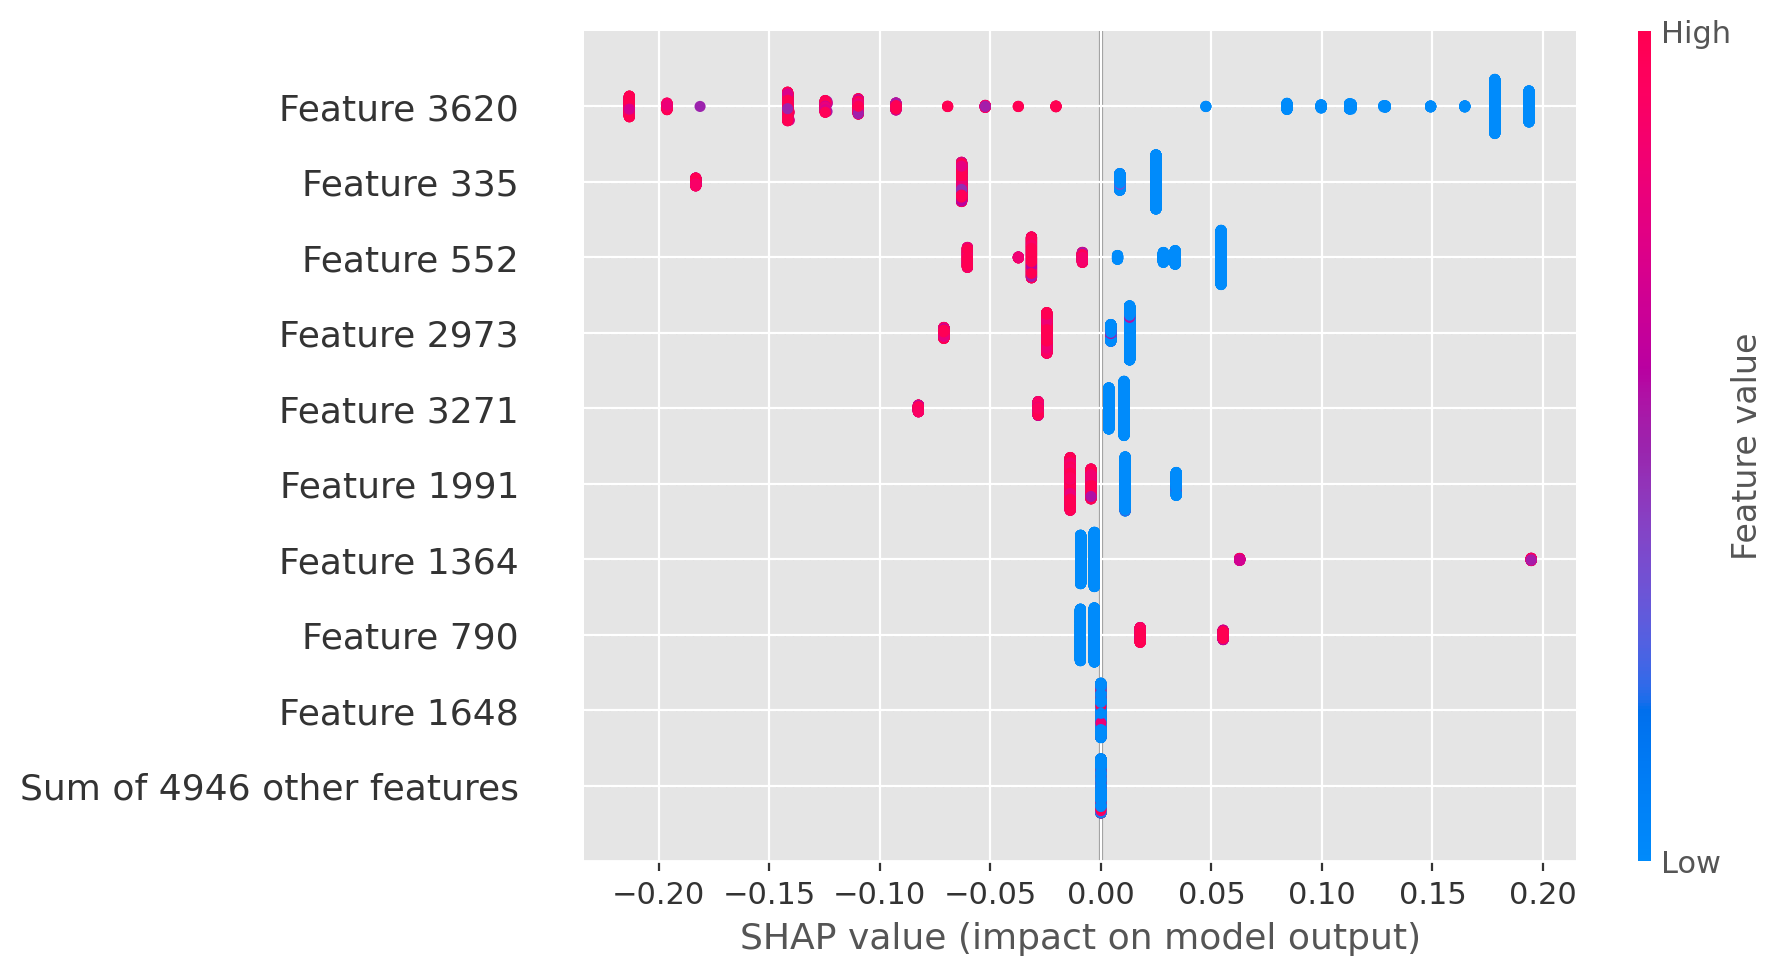

In [157]:
shap.plots.beeswarm(xgboost_shap_values)

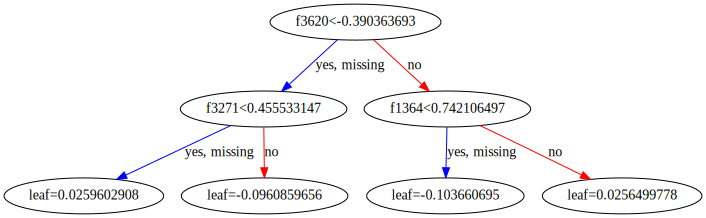

In [158]:
xgb.to_graphviz(bst, num_trees=2)

In [159]:
N = len(bst.get_fscore())
total = np.array(list(bst.get_fscore().values())).sum()
importances = bst.get_fscore()
importances.update((x, y/total) for x, y in importances.items())
importances_list = np.zeros(X_dig.shape[1])
for feature, importance in importances.items():
    importances_list[int(feature.split('f')[1])] = importance

In [160]:
selected_importances = {feature:importance for feature, importance in importances.items() if importance > 0.05}
selected_importances

{'f3620': 0.25,
 'f335': 0.16666666666666666,
 'f1364': 0.16666666666666666,
 'f1991': 0.08333333333333333,
 'f3271': 0.08333333333333333,
 'f552': 0.08333333333333333,
 'f2973': 0.08333333333333333,
 'f790': 0.08333333333333333}

In [161]:
important_features = importances_list > 0.05

In [162]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(X_dig_train[:, important_features], y_dig_train)

pred = np.ones(X_dig_test.shape[0])
pred[svm.predict(X_dig_test[:, important_features]) < 0] = -1
(pred == y_dig_test).mean()

0.9212121212121213

# Final prediction

## Artifitial dataset

In [297]:
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm.fit(X_art_train[:, art_extra_tree_selection], y_art_train)

pred = svm.predict(X_art_test[:, art_extra_tree_selection])
(pred == y_art_test).mean()

SVC(C=1, gamma=0.1, probability=True)

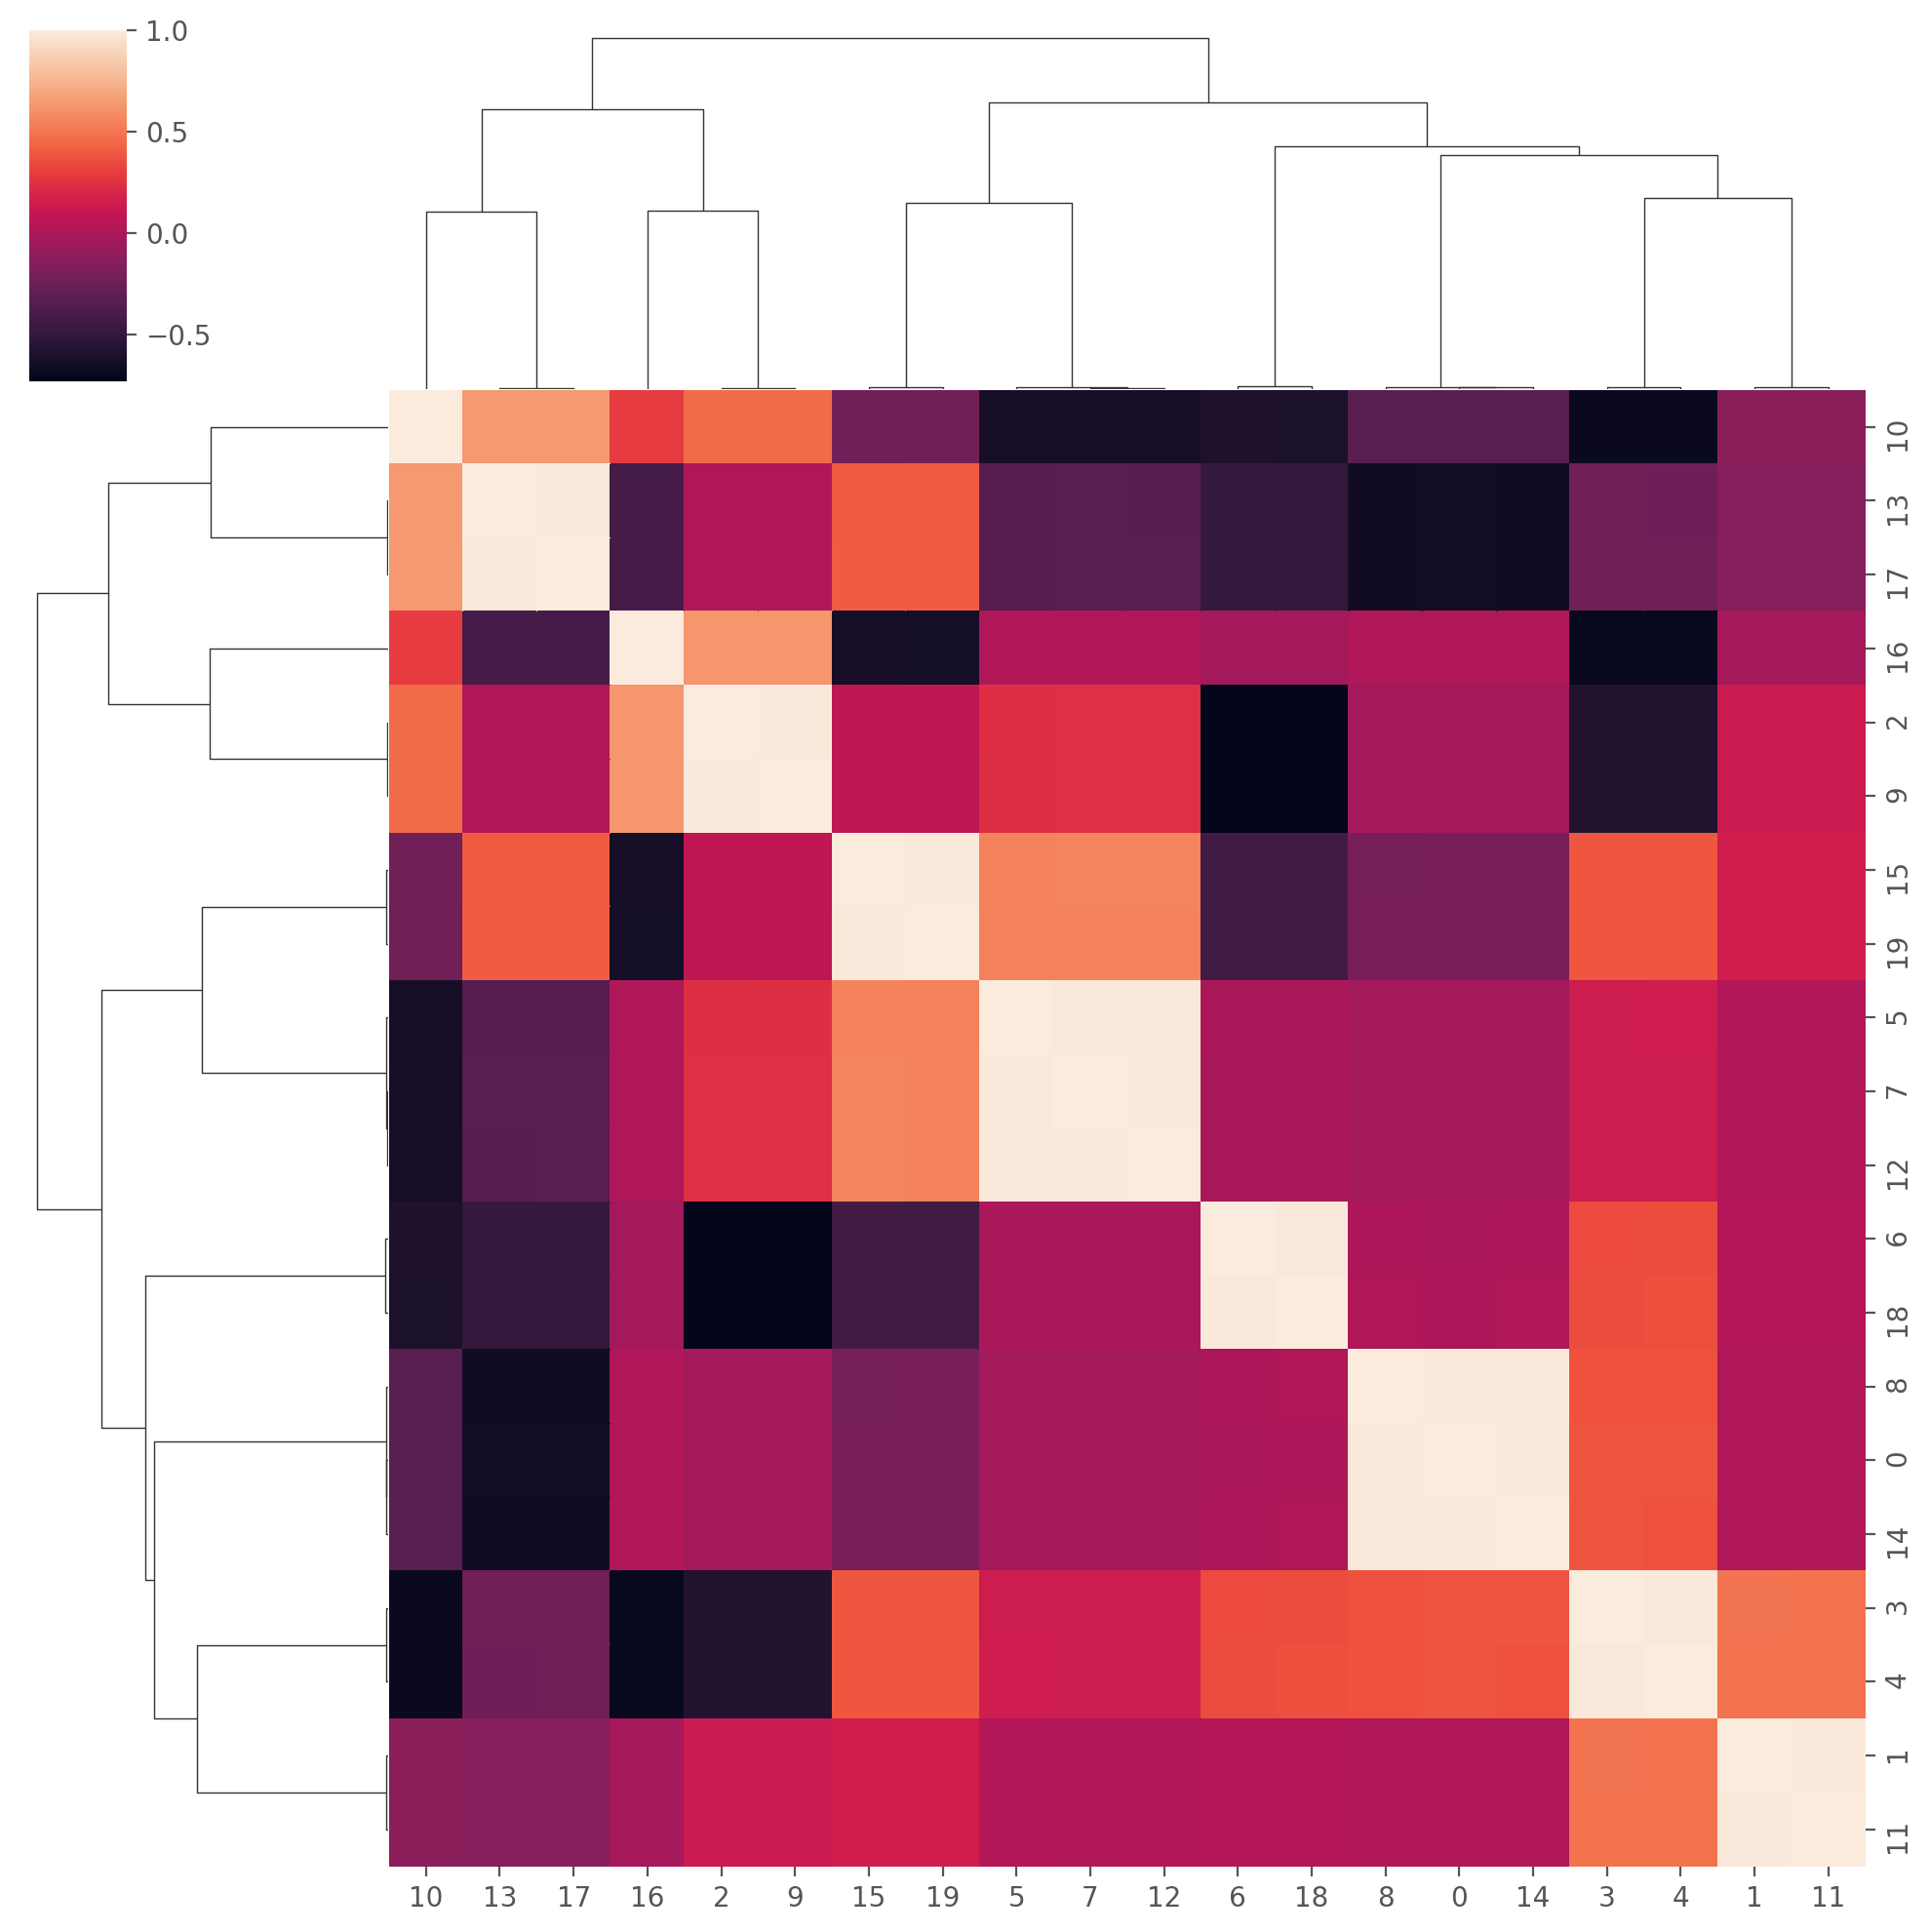

In [299]:
sns.clustermap(np.corrcoef(X_art_train[:, art_extra_tree_selection].T))

It is clear that almost all predictors have some copy so removal of copied predictors should not worse our predictor.

In [331]:
final_features = [10, 13, 16, 2, 15, 5, 6, 8, 3, 1]
redundant_features = [17, 9, 19, 7, 12, 18, 0, 14, 4, 11]

In [333]:
final_art_selection = np.where(art_extra_tree_selection)[0][final_features]

In [336]:
X_art_train[:, final_art_selection].shape

(1340, 10)

In [351]:
final_art_selection

array([338, 442, 455,  64, 453, 153, 241, 318, 105,  48])

In [348]:
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm.fit(X_art_train[:, final_art_selection], y_art_train)
pred = svm.predict(X_art_test[:, final_art_selection])
(pred == y_art_test).mean()

0.8893939393939394

In [349]:
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm.fit(X_art[:, final_art_selection], y_art)

SVC(C=1, gamma=0.1, probability=True)

In [350]:
val_pred = svm.predict_proba(val_art[:, final_features])
save_to_file(dataset='artificial', predictions=val_pred[:, 0], feature_indices=final_features)